# Electrical Engineering 4280 Final Project
## Small Object Detection on the SODA-D Dataset using YOLO

## Problem & Motivation
Small-object detection remains a challenging problem in computer vision because target objects occupy very few pixels and can be lost during feature downsampling. This limitation affects many real-world applications, including autonomous driving, surveillance, and robotics.

I chose this project because object detection is a core component of modern computer vision systems, and improving performance on small objects is especially relevant for safety-critical applications such as self-driving vehicles. This project also served as a practical, resume-oriented opportunity to work with state-of-the-art detection pipelines on a realistic dataset.


## Dataset
**Dataset** SODA-D (Small Object Detection Dataset - Driving)
**Splits** Train/Validation/Test

SODA-D contains images where many target objects are small relative to the full image resolution, making it well-suited for studying small-object detection performance. The dataset is provided in YOLO-compatible format and includes bounding box annotations for each object class.

## Model Selection
**Model family** Ultralytics YOLOv8 (YOLOv8n variant)
**Initialization** Pre-trained on COCO dataset

YOLO was selected because it provides a strong real-time detection baseline, supports fine-tuning, and automatically produces evaluation plots such as precision–recall curves, F1 curves, and confusion matrices. These features make it especially useful for controlled experimentation and analysis.

## Cell: Setup and Environment sanity check

**Goal**
- Ensure the runtime has the required libraries and GPU access via AWS Elastic Compute Cloud (EC2).

**What I did**
- For this project, I experimented with the AWS EC2 computing service. Specifically, I purchased an allocation for a G5.xlarge instance, which provide powerful GPU computing power.

**Output / Key result**
If CUDA is available, we should see `Cuda available: True` and a GPU name (e.g., an NVIDIA A10G on the g5.xlarge instance).

In [ ]:
import os, sys
import torch
from ultralytics import YOLO
from pathlib import Path


print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
else:
    print("No GPU detected")


## Test 00: Validation-only baseline (no fine-tuning)

**Goal**
Establish a baseline performance using a pre-trained YOLOv8n model without training on SODA-D dataset.

**What this test measures**
- How well off-the-shelf weights transfer to SODA-D dataset.
- A reference point for whether or not fine-tuning helps.

**Expected outcome**
This baseline is usually low for domain-specific small-object datasets, but it is useful nonetheless.

#### Analysis

**Quantitative**

//TODO: add
**Takeaways**

In [ ]:
## Code for test 00
from ultralytics import YOLO

model = YOLO("yolov8n.pt")
print("running test 00")

metrics = model.val(
    data="/home/ubuntu/project/ElectricalEngineering428Project/configs/soda.yaml",
    imgsz=640,
    device=0,
)

print(metrics)

### Test 01: Training run (640×640 baseline)

**Goal**
Fine-tune YOLOv8n on SODA-D at 640×640 to establish a trained baseline.

**Why this matters**
This is the core comparison point for later experiments. If the pipeline is
correct, this run should outperform the validation-only baseline (Test 00).

**What to look for in outputs**
- A `runs/detect/train*/results.csv` file with improving mAP over epochs
- `weights/best.pt` saved for later validation/qualitative examples

**Brief analysis (fill after running)**
- Best epoch (by mAP50–95): ___
- Best mAP50–95 / mAP50: ___ / ___
- Precision / Recall: ___ / ___

**Next**
Run the higher-resolution experiment (Test 02).



In [ ]:
## Code for test 01
import os, sys

from pathlib import Path

PROJECT_ROOT = Path("..").resolve()
sys.path.append(str(PROJECT_ROOT))
print("running test 01")
print("Project root: ", PROJECT_ROOT)

from src.train_yolo import train_baseline

train_baseline(epochs=20,
               imgsz=640,
               batch=8,
)

## Test 02: Fine-tune YOLOv8n at 960x960 (higher resolution)

**Goal**
Test whether higher input resolution improves small-object detection by preserving more pixel details.

**What changed vs Test 01**
- `imgsz` increased from 640 -> 960
- Other parameters kept contant (`epochs=20`, `batch=8`)

**What to look for**
Small objects occupy very few pixels at 640x640, so increasing resolution should increase recall and improve overall AP.


In [ ]:
## Code for test 02
import os, sys

from pathlib import Path

PROJECT_ROOT = Path("..").resolve()
sys.path.append(str(PROJECT_ROOT))
print("running test 02")
print("Project root: ", PROJECT_ROOT)

from src.train_yolo import train_baseline

train_baseline(epochs=20,
               imgsz=960,
               batch=8,
)


### Test 03: Motivation for hyperparameter update (second 640×640 run)

**Goal**
Run another 640×640 training experiment, but with targeted augmentation /
training adjustments, to see whether we can improve small-object performance
without increasing resolution.

**What changed (vs Test 01)**
We enable multi-scale training and adjust scale + HSV augmentation:

- `multi_scale=True`: train on varying input sizes to improve scale robustness
- `scale=0.9`: allow stronger random resizing; can help generalization
- HSV jitter (`hsv_h=0.02, hsv_s=0.7, hsv_v=0.4`): improves robustness to lighting

**Hypothesis**
If performance improves at 640×640, then augmentation/training strategy is a
viable alternative to increasing resolution. If not, resolution is likely the
dominant factor for this dataset.



In [ ]:
## Code for test 03
import os, sys

from pathlib import Path

PROJECT_ROOT = Path("..").resolve()
sys.path.append(str(PROJECT_ROOT))
print("running test 03")
print("Project root: ", PROJECT_ROOT)

from src.train_yolo import train_baseline

train_baseline(epochs=20,
               imgsz=640,
               batch=8,
)

## Results Summary and Comparison

Across all experiments, the best-performing model was the higher-resolution
fine-tuning run (Test 02), saved as `runs/detect/train9_best`.

```2	runs/detect/analysis_pack/train9	19	0.12455	0.04406	runs/detect/analysis_pack/train9/results.csv```


**Best run:** Test 02  
**Best epoch:** 19  

I report two standard COCO-style metrics:

- **mAP@50**: Average Precision at IoU = 0.50 (lenient localization)
- **mAP@50–95**: Average Precision averaged over IoU thresholds 0.50–0.95 (stricter)

**Best model performance:**
- **mAP@50:** ≈ 0.125
- **mAP@50–95:** ≈ 0.044

For comparison, the 640×640 fine-tuned baseline (Test 01) achieved:
- **mAP@50:** ≈ 0.050
- **mAP@50–95:** ≈ 0.015

This corresponds to roughly a **2.5× improvement in mAP@50**, indicating
that higher input resolution significantly improves small-object detection
on the SODA-D dataset.


## Student Summary (Personal takeaways)
Among all students in this class, hardware issues seemed to play a large role in terms of satisfaction with the results. In the case of this project, my laptop is indefinitely out of service. Along with it went my MFA device for AWS, and my .pem file, which allowed SSH into the AWS instance. Because of this, I was locked-out of the project from noon on Sunday 12/15/2025, until 8:00pm Wednesday 12/18/2025. 

### What I learned (hardware issues)
Regardless of the large amount of overhead time I spent setting up cloud computing on AWS EC2, it's important to be aware of possible hardware issues. I personally felt that this was a reliable way to keep my project roboust against local hardware issues, but its important to be careful regardless.

### Conclusion on AWS
The other students had lots of reliability issues (disconnects, timeouts) when running their code on Colab/Kaggle. For me, AWS was extremely reliable, and I'd recommend that future classes use this, assuming they have cost in mind. This project cost ~$50.00, which was covered under the AWS credit for new accounts. Also note that I used a higher-power G5 instance, which has higher costs. The G5 instance also requires you to request for an increase in vGPU instance allocations, which adds to the overhead time (several days of waiting for response). On a final note, AWS seems to be a useful skill that employers are looking for. In addition to Elastic Compute Cloud, I used AWS Lambda and EventBridge to deactivate my instance at night. Please advise students on the risks of using non-shared 'dedicated' instances; these can cost five-figures/month!

In [2]:
from pathlib import Path

RUNS_DIR = Path("runs")

csvs = sorted(RUNS_DIR.rglob("results.csv"))
print(f"results.csv files found: {len(csvs)}")

for p in csvs[:25]:
    print(p)




results.csv files found: 13
runs/detect/analysis_pack/train11/results.csv
runs/detect/analysis_pack/train8/results.csv
runs/detect/analysis_pack/train9/results.csv
runs/detect/train/results.csv
runs/detect/train11/results.csv
runs/detect/train2/results.csv
runs/detect/train3/results.csv
runs/detect/train4/results.csv
runs/detect/train5/results.csv
runs/detect/train6/results.csv
runs/detect/train7/results.csv
runs/detect/train8/results.csv
runs/detect/train9_best/results.csv


In [8]:
import pandas as pd

def load_results(csv_path):
    df = pd.read_csv(csv_path)
    df.columns = [c.strip() for c in df.columns]
    return df

def pick_map_cols(df):
    cols = list(df.columns)

    # 1) Prefer exact Ultralytics names (most common)
    map50 = "metrics/mAP50(B)"
    map5095 = "metrics/mAP50-95(B)"
    if map50 in cols and map5095 in cols:
        return map50, map5095

    # 2) Fallback: any column containing these substrings
    map50_col = next((c for c in cols if "metrics/mAP50" in c and "95" not in c), None)
    map5095_col = next((c for c in cols if "metrics/mAP50-95" in c), None)
    return map50_col, map5095_col

rows = []
skipped = []

for csv_path in csvs:
    run_dir = csv_path.parent
    df = load_results(csv_path)

    map50_col, map5095_col = pick_map_cols(df)
    if map50_col is None or map5095_col is None:
        skipped.append((str(run_dir), list(df.columns)))
        continue

    best_i = int(df[map50_col].idxmax())
    best = df.loc[best_i]

    rows.append({
        "run_dir": str(run_dir),
        "best_epoch": best_i,
        "best_mAP50": float(best[map50_col]),
        "best_mAP50_95": float(best[map5095_col]),
        "results_csv": str(csv_path),
    })

print("kept runs:", len(rows))
print("skipped runs:", len(skipped))
if skipped:
    print("\nExample skipped run + its columns:")
    print(skipped[0][0])
    print(skipped[0][1])

leaderboard = pd.DataFrame(rows).sort_values("best_mAP50", ascending=False)
leaderboard.head(15)



kept runs: 13
skipped runs: 0


,run_dir,best_epoch,best_mAP50,best_mAP50_95,results_csv
2,runs/detect/analysis_pack/train9,19,0.12455,0.04406,runs/detect/analysis_pack/train9/results.csv
12,runs/detect/train9_best,19,0.12455,0.04406,runs/detect/train9_best/results.csv
1,runs/detect/analysis_pack/train8,19,0.04964,0.01537,runs/detect/analysis_pack/train8/results.csv
11,runs/detect/train8,19,0.04964,0.01537,runs/detect/train8/results.csv
9,runs/detect/train6,2,0.03686,0.01475,runs/detect/train6/results.csv
0,runs/detect/analysis_pack/train11,17,0.03628,0.01083,runs/detect/analysis_pack/train11/results.csv
4,runs/detect/train11,17,0.03628,0.01083,runs/detect/train11/results.csv
10,runs/detect/train7,2,0.02511,0.00706,runs/detect/train7/results.csv
3,runs/detect/train,0,0.00000,0.00000,runs/detect/train/results.csv
8,runs/detect/train5,0,0.00000,0.00000,runs/detect/train5/results.csv



confusion_matrix*.png


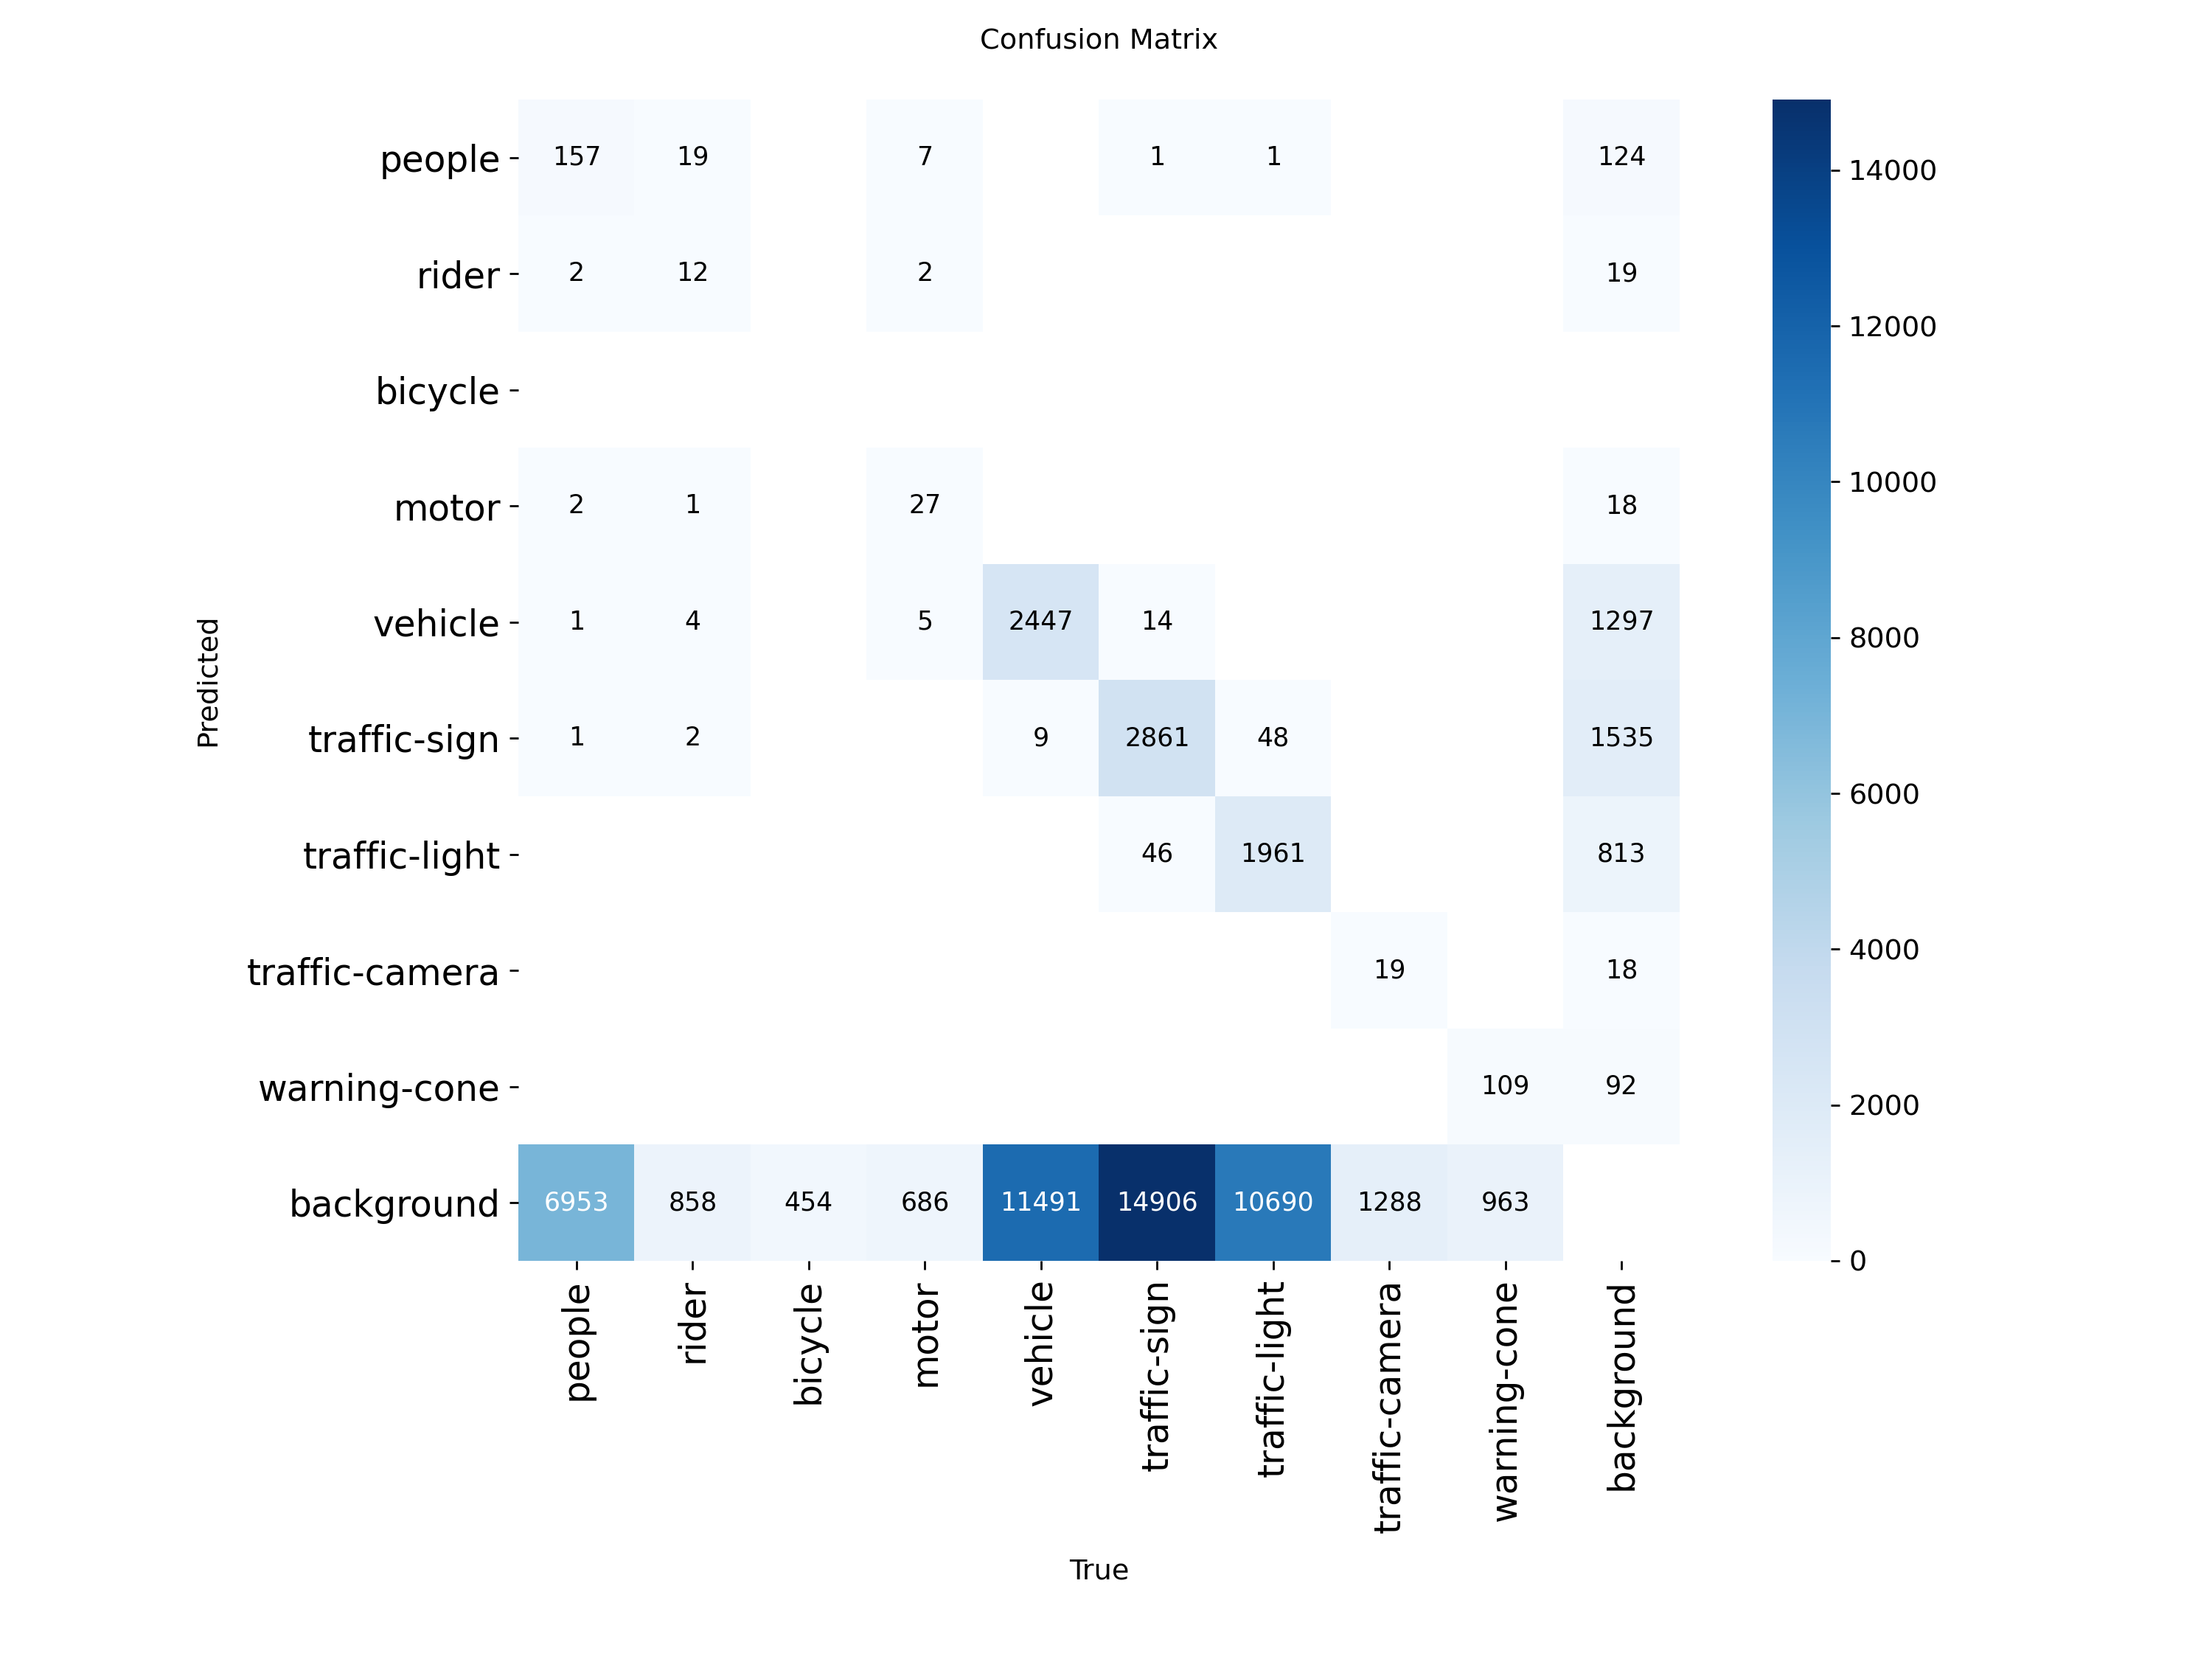

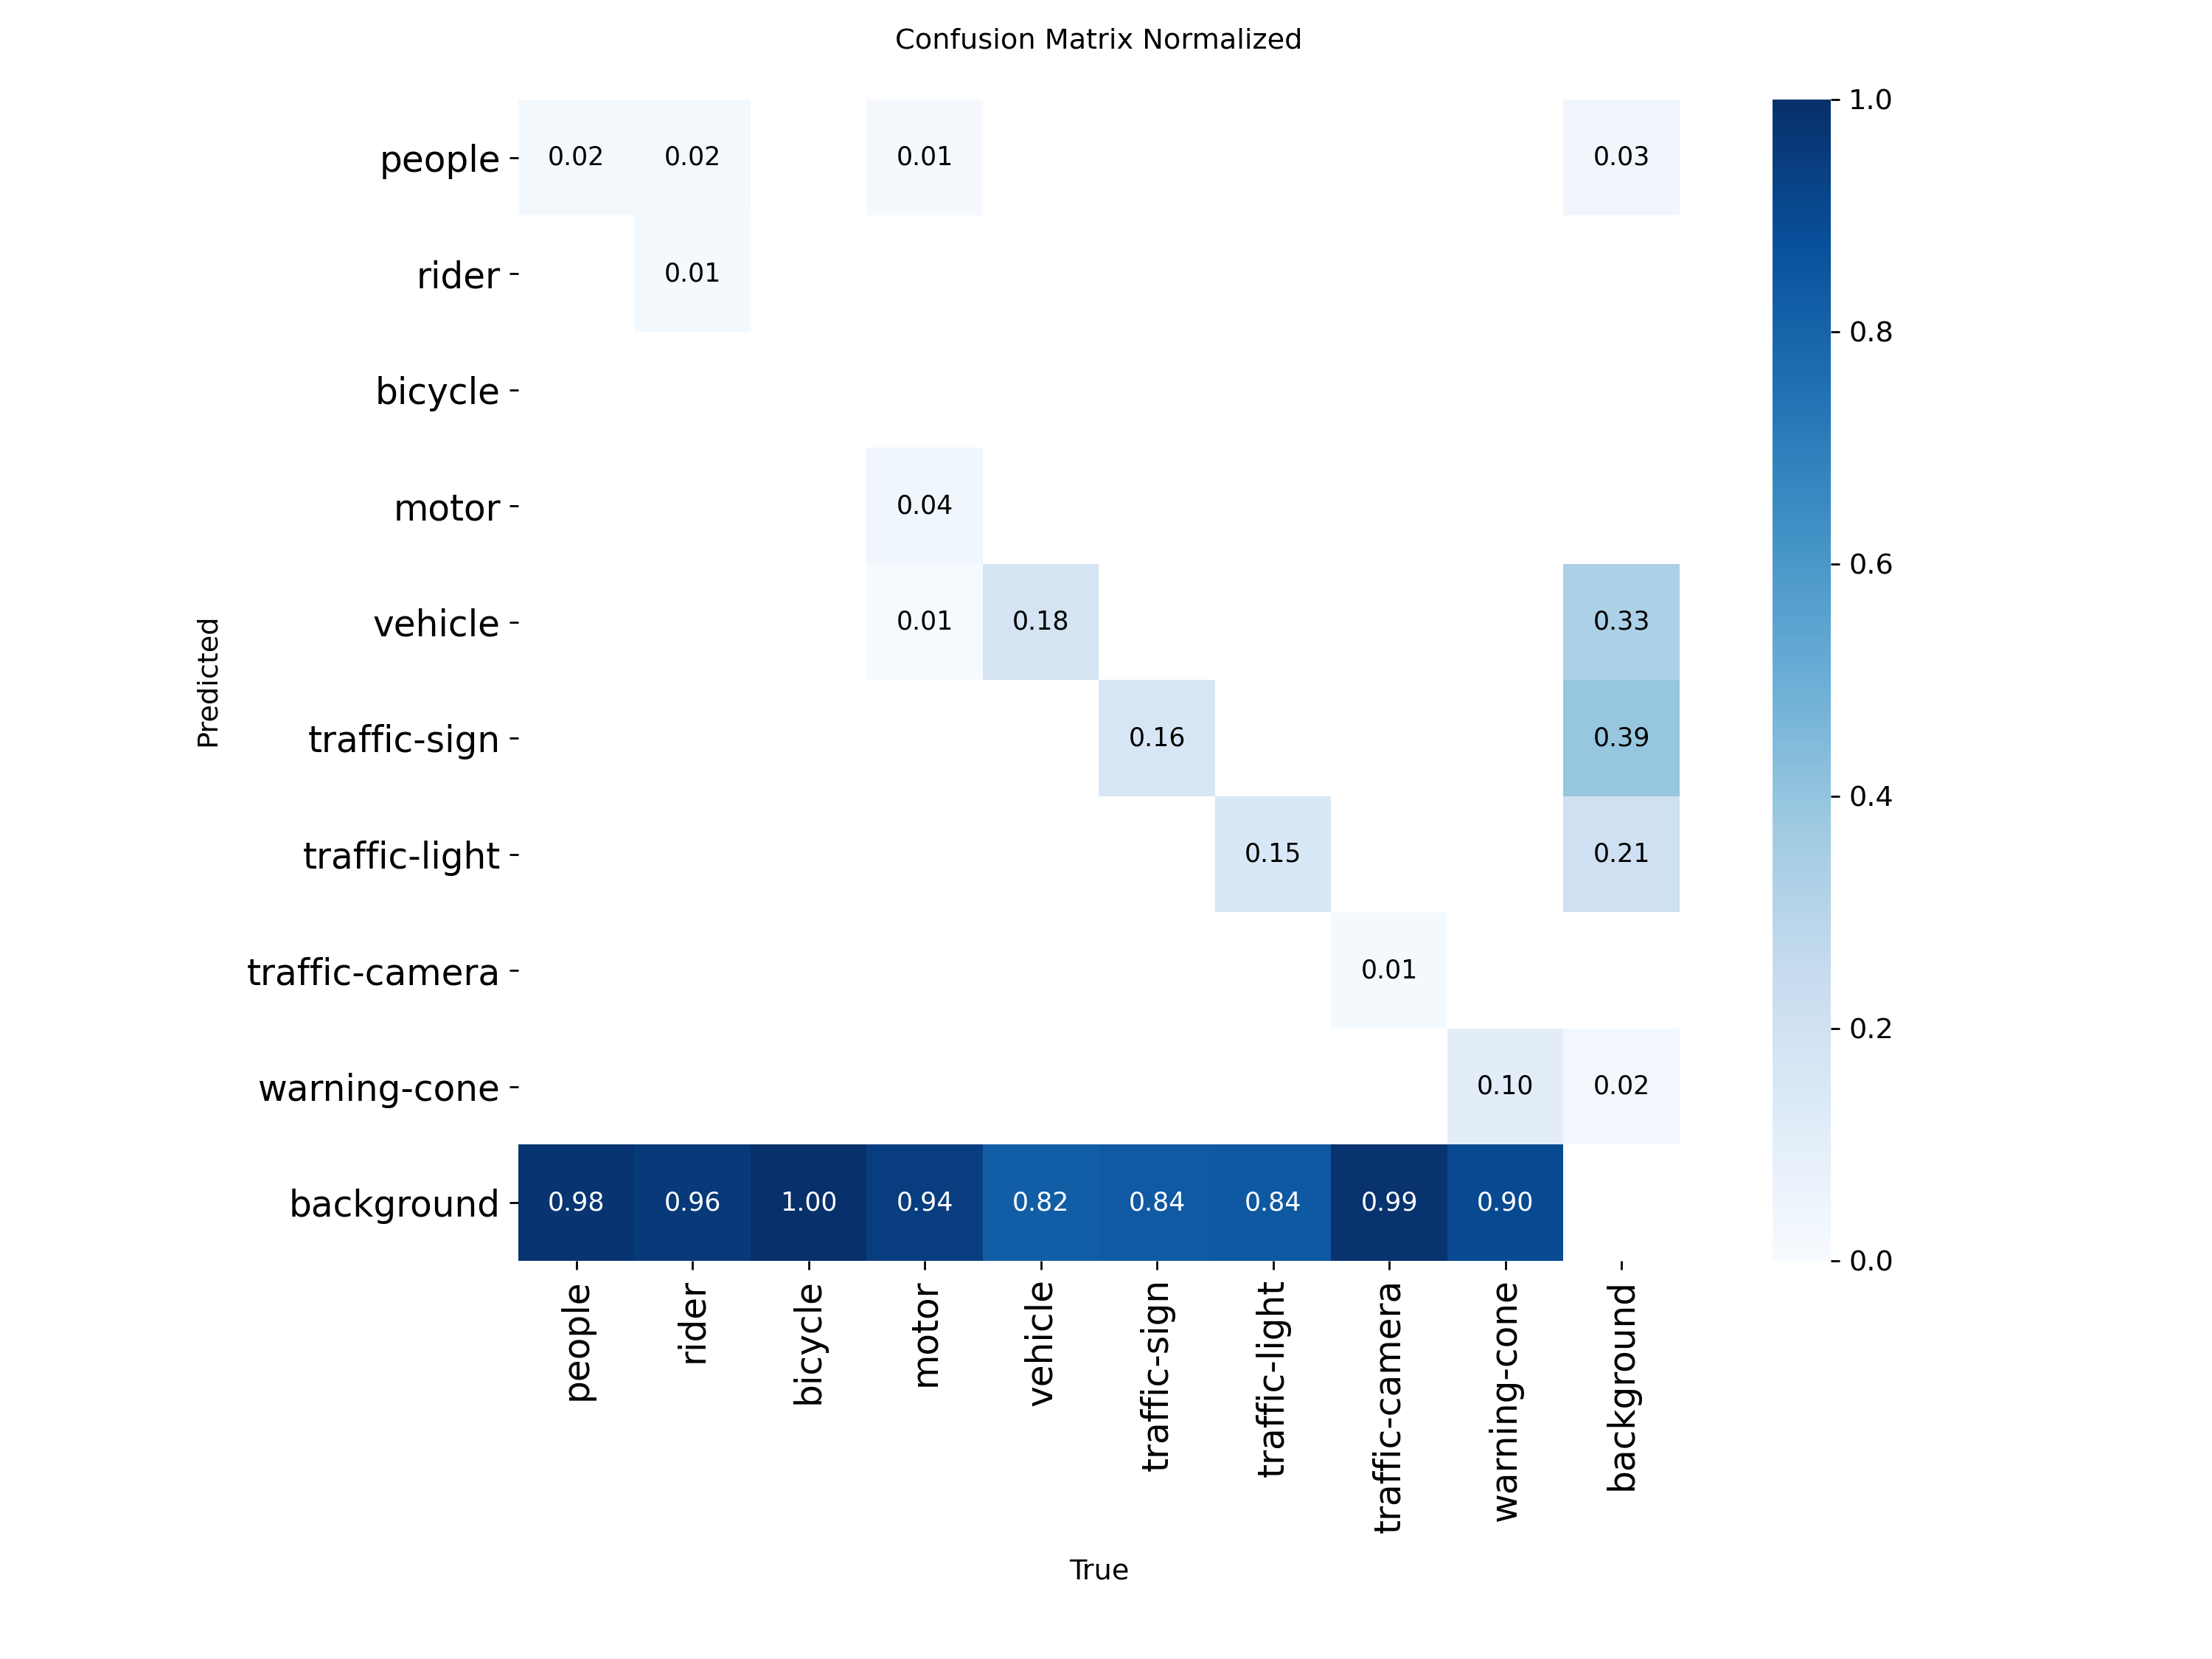


*PR_curve*.png


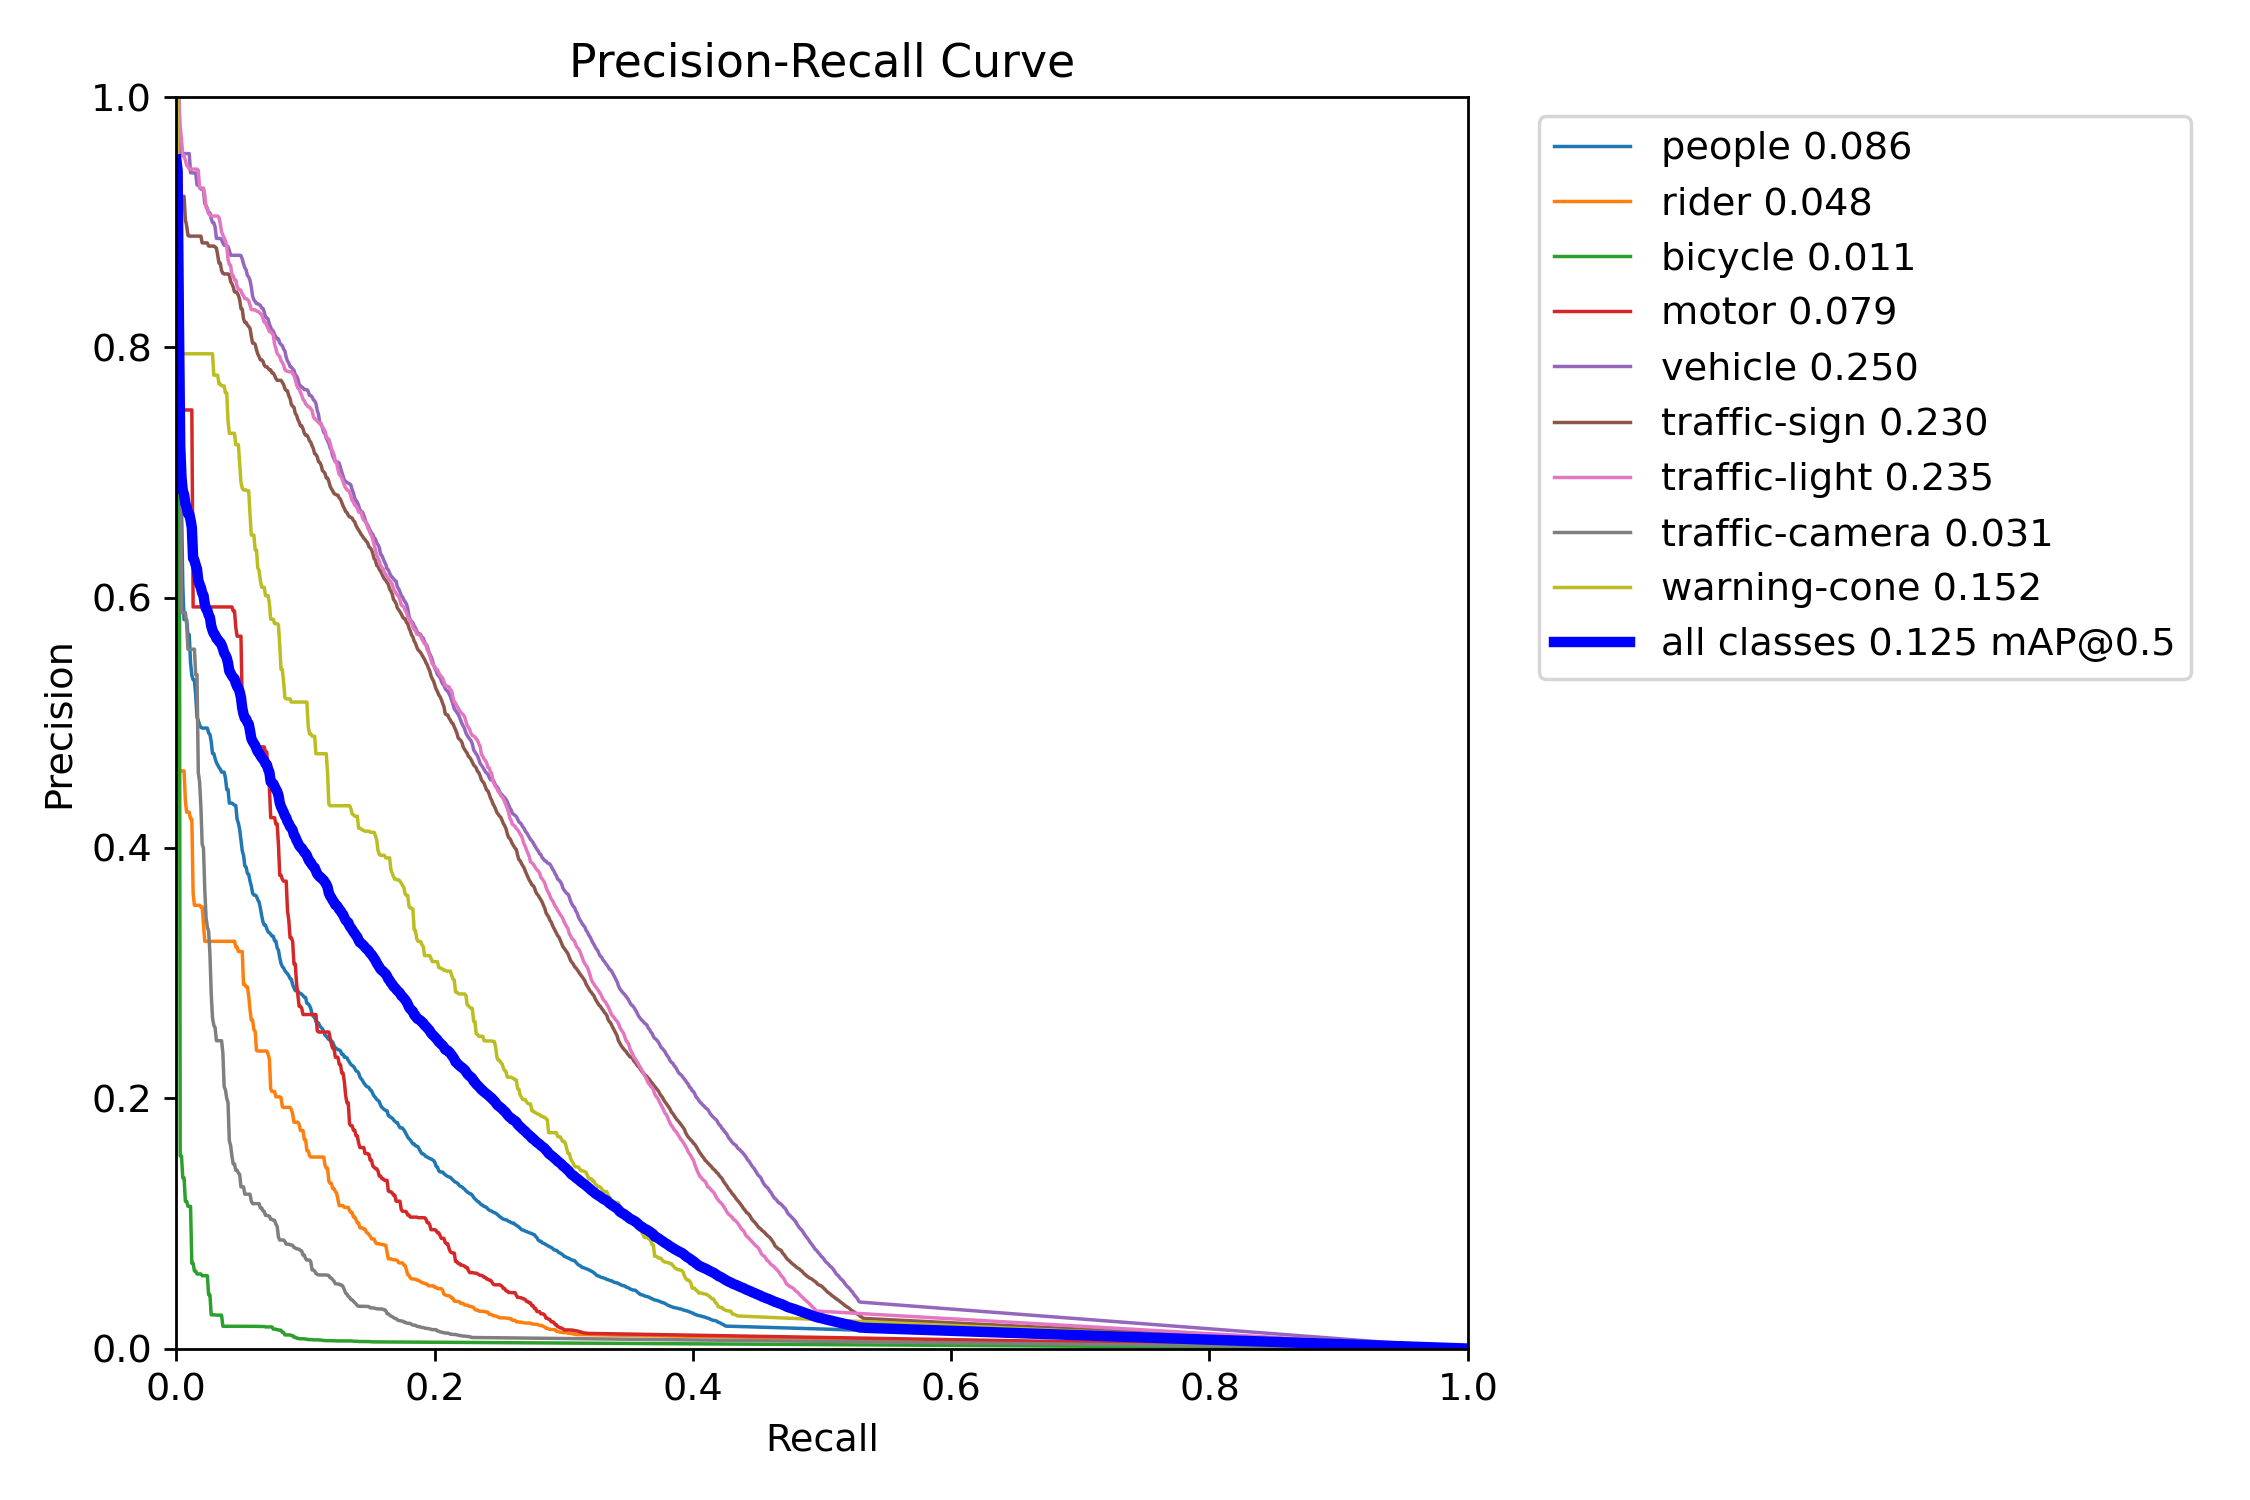


*F1_curve*.png


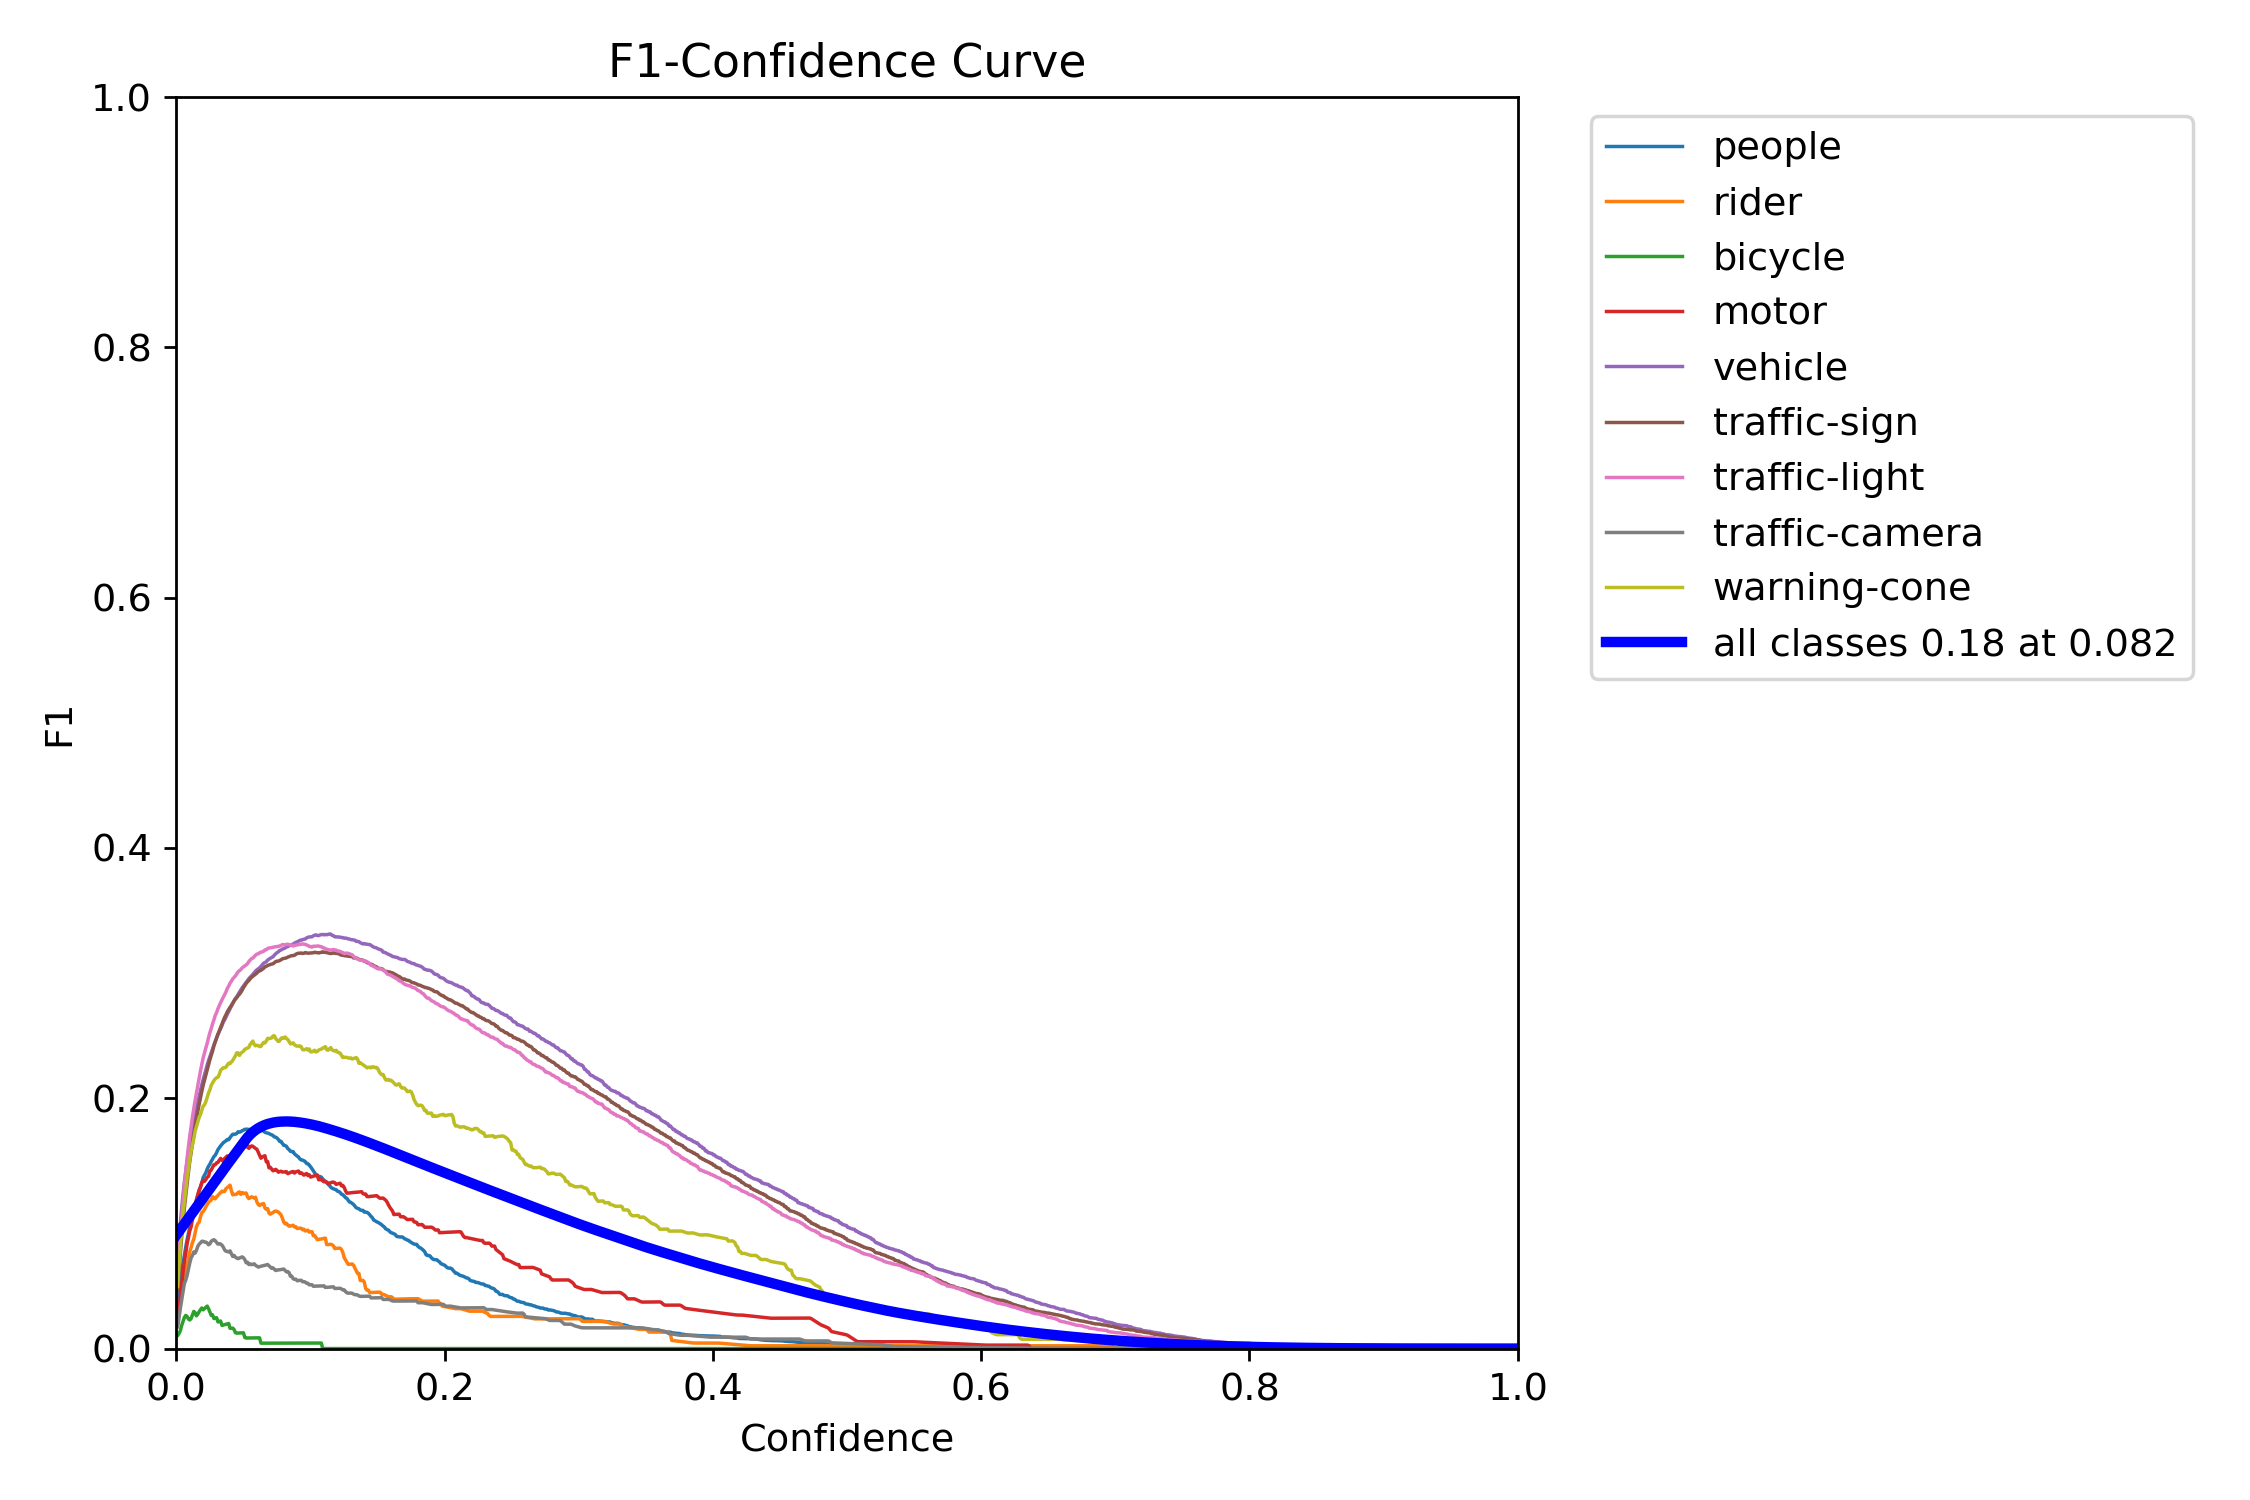


val_batch*.jpg


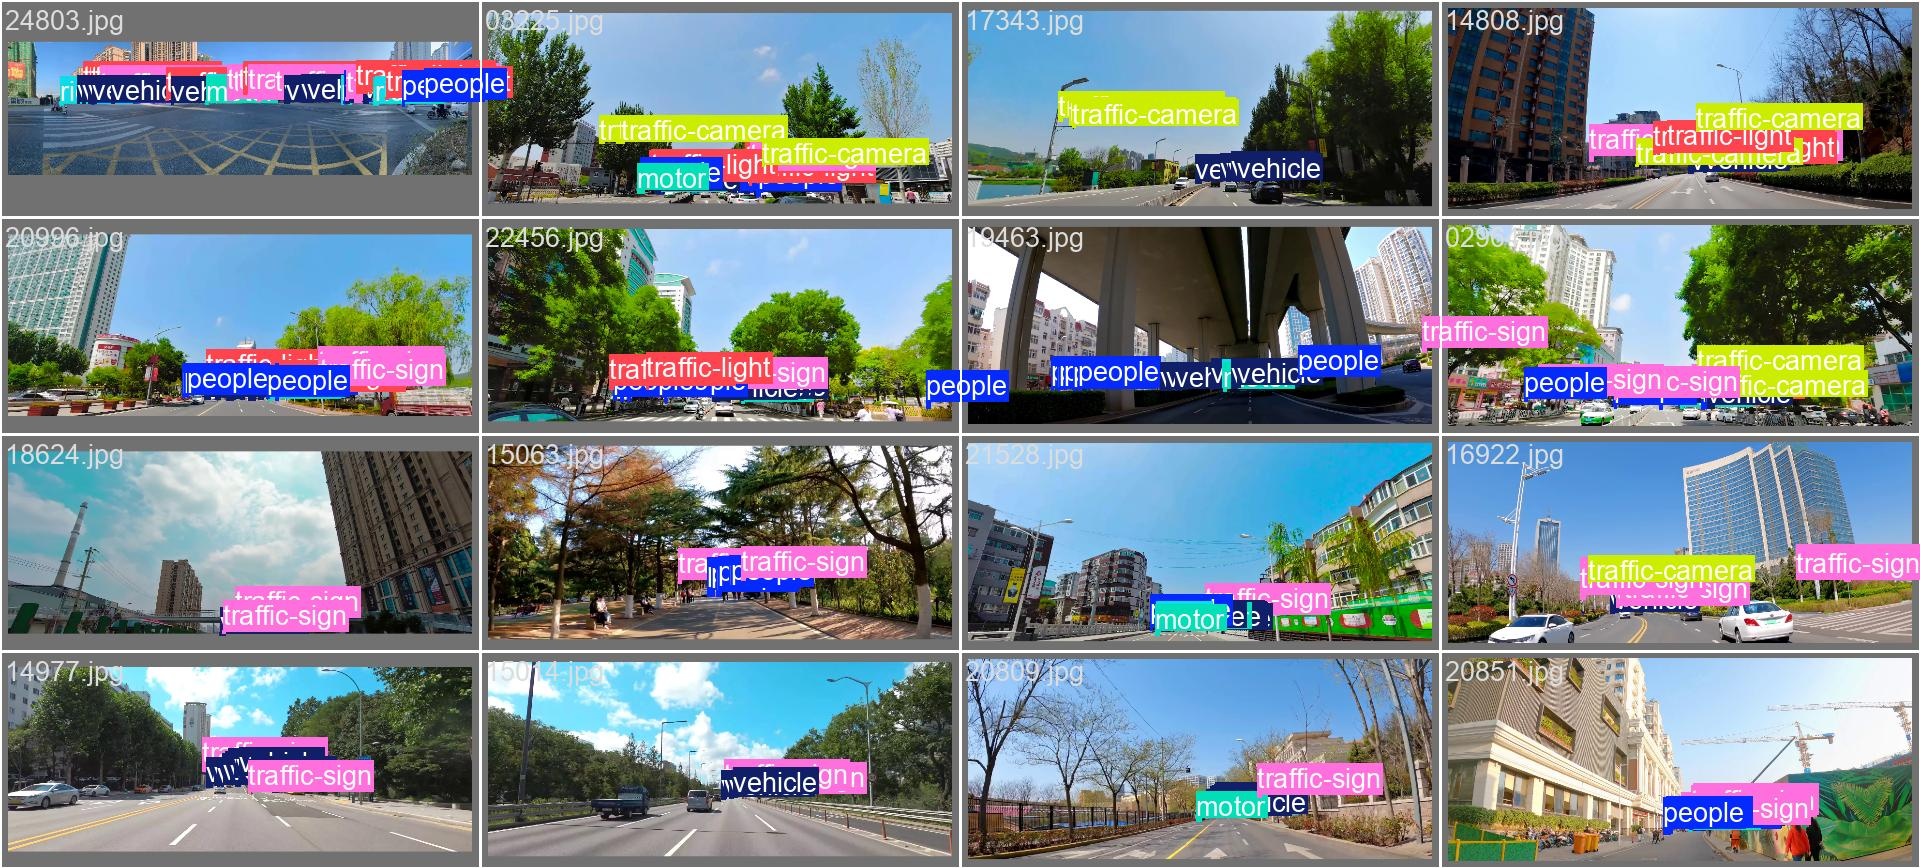

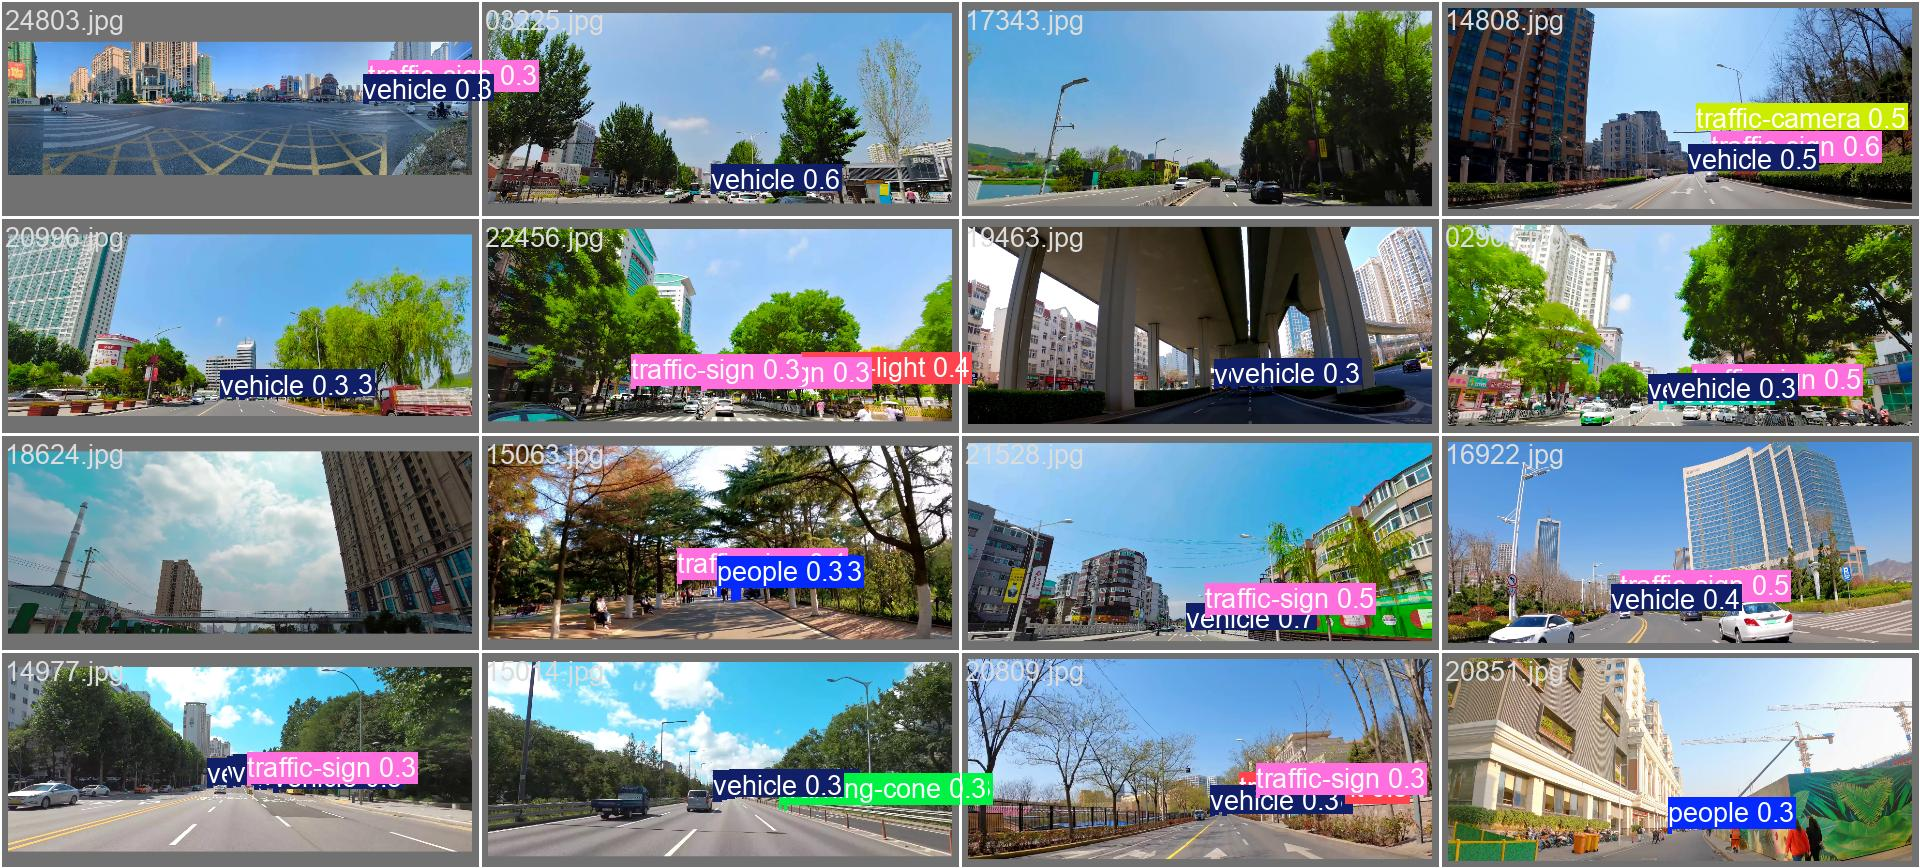

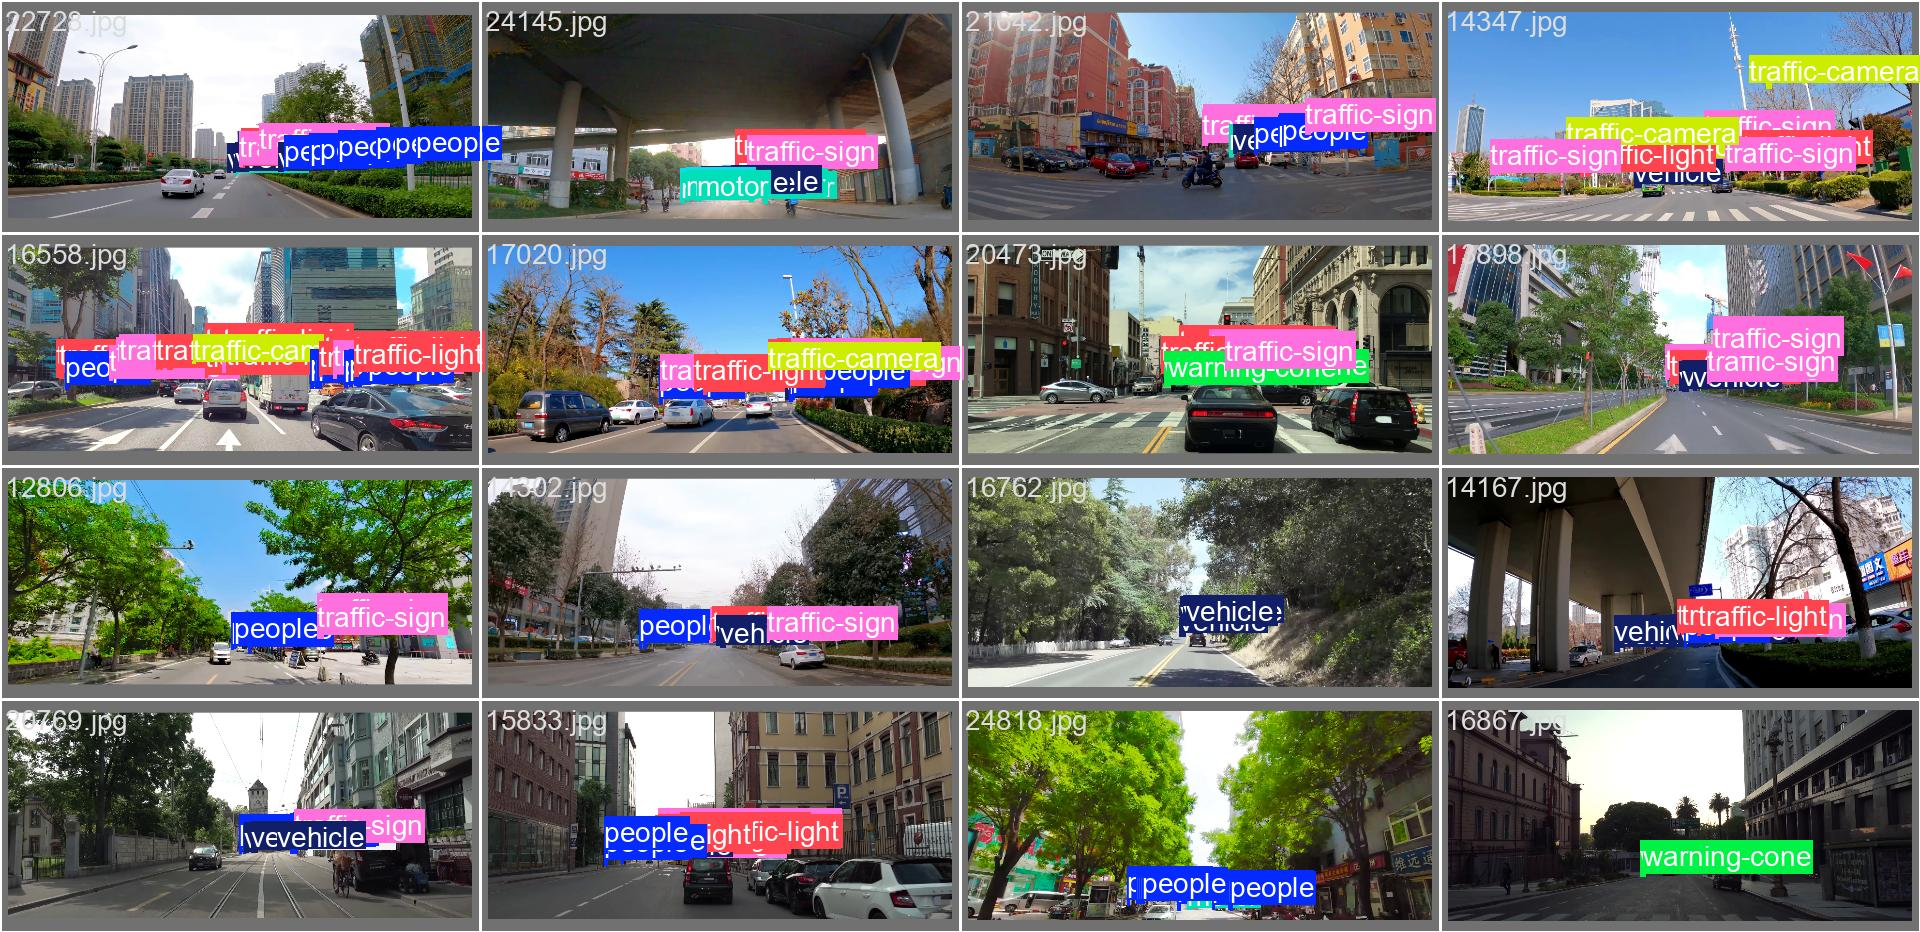

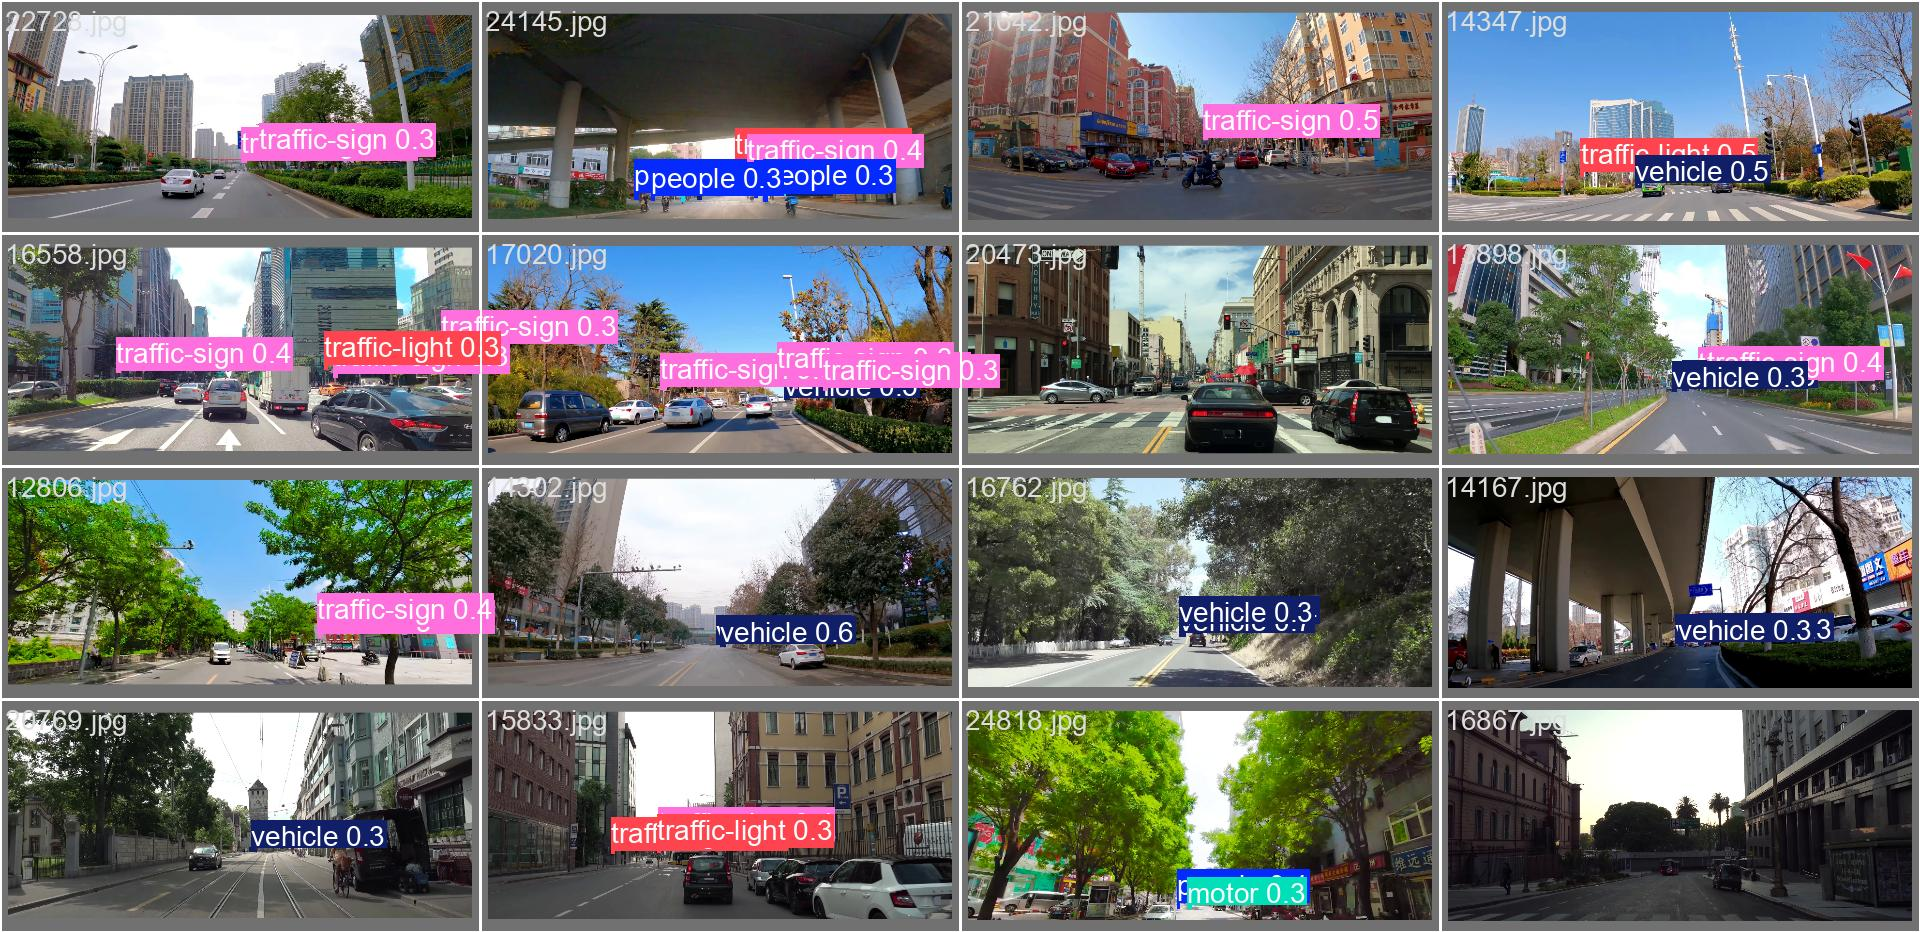

In [4]:
## Show some photos from our best-performing model
from IPython.display import Image, display
from pathlib import Path

best_run = Path("runs/detect/train9_best")

patterns = [
    "confusion_matrix*.png",
    "*PR_curve*.png",
    "*F1_curve*.png",
    "val_batch*.jpg",
    "pred*.jpg",
]

for pat in patterns:
    imgs = sorted(best_run.glob(pat))
    if imgs:
        print(f"\n{pat}")
        for img in imgs[:4]:
            display(Image(filename=str(img)))



### Exploratory Continued work - YOLO + Segmentation for some hueristics

I plan on continuing this project now that I have regained access. I'd like to use this knowledge in an attempt to get a job in Computer Vision! Here is my future plan:





In [ ]:
# code for segmentation stuff
import os, sys

from pathlib import Path
from ultralytics import YOLO

PROJECT_ROOT = Path("..").resolve()
sys.path.append(str(PROJECT_ROOT))
print("running segmentation stuff")
print(f"project root: {PROJECT_ROOT}")

BEST_MODEL_PATH = sys.path.append(str(PROJECT_ROOT), "runs", "detect", "train9_best", "best.pt")
DATA_PATH = sys.path.append(str(PROJECT_ROOT), "configs", "soda.yaml")
IMGSZ = 640

yolo_model = YOLO(BEST_MODEL_PATH)

# yolo_model.do_something()






running segmentation stuff
project root: /home/ubuntu/project/ElectricalEngineering428Project
